In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# additional functions used in imrect
def order_corners(corners):
    """
    Define a function to take in a set of 4 corner points (2D coordinates) and order them clockwise,
    starting from the top-left corner. Ordering is required to ensure correct perspective transformation
    when using cv2.getPerspectiveTransform() later.
    """
    # initialize an empty 4x2 numpy array to store the ordered corner points
    rect = np.zeros((4, 2), dtype="float32")

    # sum the x and y coordinates for each corner point
    s = corners.sum(axis=1)
    rect[0] = corners[np.argmin(s)] # represents corner with smallest sum of x and y coordinates - top left corner
    rect[2] = corners[np.argmax(s)] # represents corner with largest sum of x and y coordinates - bottom right corner

    # calculate the diffrence between x and y coordinates for each corner point
    diff = np.diff(corners, axis=1)
    rect[1] = corners[np.argmin(diff)] # corner with smallest difference - top right corner
    rect[3] = corners[np.argmax(diff)] # corner with largest difference - bottom left corner

    return rect


def rectify_image(image, quadrilateral_points, rectified_size=(1200,1000), padding=50):
    """
    Takes an input image, the corner points of the found quadrilateral, the desired output size and default padding
    and returns an output 
    """
    # unpack the rectified default size into width and height
    width, height = rectified_size

    # define the output rectangle's corner points, with padding, since we do not just want to extract the object of interest
    output_rectangle_points = np.float32([[0 + padding, 0 + padding],
                                          [width - padding, 0 + padding],
                                          [width - padding, height - padding],
                                          [0 + padding, height - padding]])


    # calculate the perspective transform matrix M using the input quadrilateral corner points and output rectangle corner points
    # This is same as in the lecture notes for matrix H, and we use this to transform the input image into the rectified image.
    M = cv2.getPerspectiveTransform(np.float32(quadrilateral_points), output_rectangle_points)

    # Apply the perspective transform matrix M to the input image using warpPerspective
    rectified_image = cv2.warpPerspective(image, M, (width, height))

    # Returns the rectified image as a numpy array
    return rectified_image


def imrect(im1):
    """
    Takes in a numpy array for input image and returns the rectified image as a numpy array
    """
    ##################### Start of the main function for imrect function #############################
    image_copy = im1.copy()
    
    # convert input image to gray scale
    gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    
    # apply a gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # apply canny edge detection on blurred image
    edged = cv2.Canny(blurred, 75, 200)
    
    # since test1.jpg is a tricky image to detect with many broken lines in the contours, we need to do some morphological operations
    # perform morphological operations (dilation followed by erosion)
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(edged, kernel, iterations=3)
    closed = cv2.erode(dilated, kernel, iterations=3)
    
    # contours are found using findContours, returning a list of contours in the image
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
    # original, does not detect test1.jpg well for the contours, hence we use morphological operations.
    # contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # the largest contour can be found using the MAX area, since the homework says the input image will always
    # have a prominent rectangular boundary in a monochrome background.
    largest_contour = max(contours, key=cv2.contourArea)
    
    # arcLength is used to find the perimeter of the largest contour found. Multiply by 0.02 to obtain epsilon,
    # which is used to control the approximation accuracy in approxPolyDP.
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    # approximates the contour shape. Result is a simplified contour that retains the general shape but with fewer vertices.
    # used to extract the 4 corner points
    approx_corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    
    # If the largest contour has 4 corner points as in a rectangle, proceed with rectification
    # if not, raise exception and that the largest contour in the input image is not a quadrilateral.
    if len(approx_corners) == 4:
        # order the corner points
        ordered_corners = order_corners(approx_corners.reshape(4, 2))
        
        # Visualize the contour and corner points on the original image
        # draw contours on the image_copy, draws contours in place
        cv2.drawContours(image_copy, [approx_corners], -1, (0,255,0), 2)

        # draw the corner points on the image_copy
        for point in approx_corners:
            x, y = point[0]
            cv2.circle(image_copy, (x,y), 10, (255,0,0), -1)
            
        # use matplotlib to show the image with the contours and the corner points detected
        image_copy_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        plt.imshow(image_copy_rgb)
        plt.title('Contours & Corner Points on original image')
        plt.axis('off')
        plt.show()
        
        # rectify the image with the order points, and desired output size
        rectified_image = rectify_image(im1, ordered_corners)
        
        # visualize the rectified image
        rectified_image_rgb = cv2.cvtColor(rectified_image, cv2.COLOR_BGR2RGB)
        plt.imshow(rectified_image_rgb)
        plt.title('Rectified Image Output')
        plt.axis('off')
        plt.show()
        
        return rectified_image
    else:
        raise Exception("The largest contour is not a quadrilateral.")


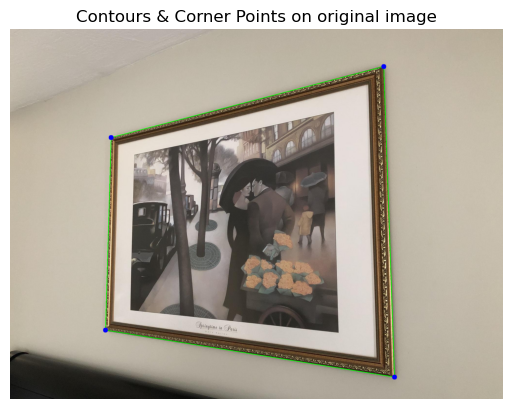

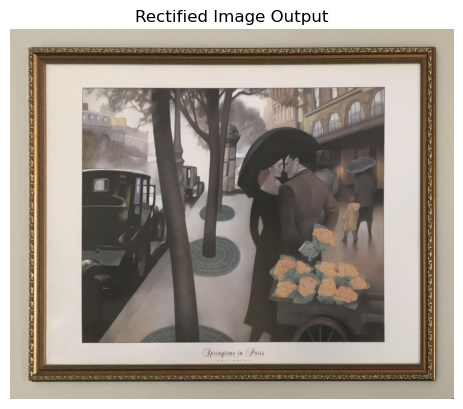

In [2]:
# Read the input image
input_image = cv2.imread("./data/test1.jpg")

# Apply the rectification
rectified_image = imrect(input_image)

# # Save the output image
# cv2.imwrite("rectified_image.jpg", rectified_image)

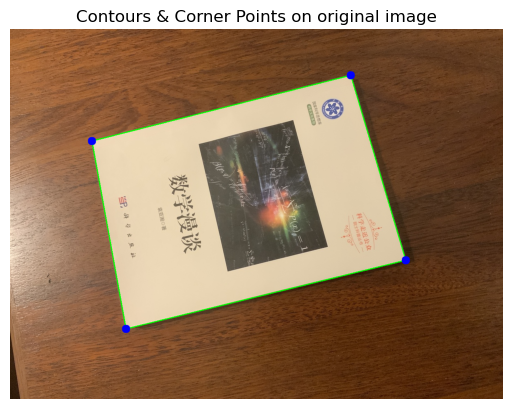

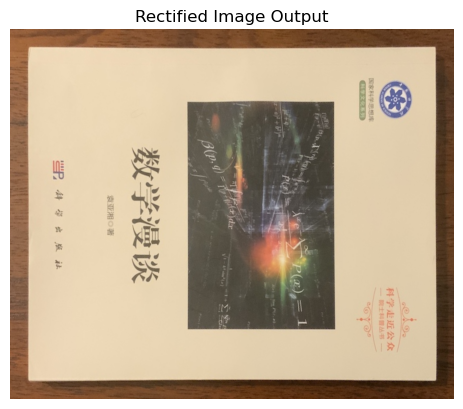

In [3]:
# Read the input image
input_image = cv2.imread("./data/test2.jpg")

# Apply the rectification
rectified_image = imrect(input_image)

In [7]:
image = np.array(cv2.imread('./data/test1.jpg', -1), dtype=np.float32)/255.

image2 = cv2.imread('./data/test1.jpg')

In [8]:
print(len(image))
print(type(image))
print(len(image2))
print(type(image2))

1512
<class 'numpy.ndarray'>
1512
<class 'numpy.ndarray'>


In [9]:
image2

array([[[179, 191, 201],
        [179, 191, 201],
        [179, 191, 201],
        ...,
        [154, 175, 183],
        [153, 174, 182],
        [152, 173, 181]],

       [[177, 189, 199],
        [177, 189, 199],
        [176, 188, 198],
        ...,
        [152, 173, 181],
        [151, 172, 180],
        [149, 170, 178]],

       [[177, 189, 199],
        [177, 189, 199],
        [176, 188, 198],
        ...,
        [150, 171, 179],
        [149, 170, 178],
        [148, 169, 177]],

       ...,

       [[ 24,  24,  24],
        [ 23,  23,  23],
        [ 23,  23,  23],
        ...,
        [160, 179, 187],
        [161, 180, 188],
        [161, 180, 188]],

       [[ 24,  24,  24],
        [ 23,  23,  23],
        [ 23,  23,  23],
        ...,
        [160, 179, 187],
        [161, 180, 188],
        [162, 181, 189]],

       [[ 28,  28,  28],
        [ 26,  26,  26],
        [ 25,  25,  25],
        ...,
        [160, 179, 187],
        [161, 180, 188],
        [162, 181, 189]]

In [10]:
image

array([[[0.7019608 , 0.7490196 , 0.7882353 ],
        [0.7019608 , 0.7490196 , 0.7882353 ],
        [0.7019608 , 0.7490196 , 0.7882353 ],
        ...,
        [0.6039216 , 0.6862745 , 0.7176471 ],
        [0.6       , 0.68235296, 0.7137255 ],
        [0.59607846, 0.6784314 , 0.70980394]],

       [[0.69411767, 0.7411765 , 0.78039217],
        [0.69411767, 0.7411765 , 0.78039217],
        [0.6901961 , 0.7372549 , 0.7764706 ],
        ...,
        [0.59607846, 0.6784314 , 0.70980394],
        [0.5921569 , 0.6745098 , 0.7058824 ],
        [0.58431375, 0.6666667 , 0.69803923]],

       [[0.69411767, 0.7411765 , 0.78039217],
        [0.69411767, 0.7411765 , 0.78039217],
        [0.6901961 , 0.7372549 , 0.7764706 ],
        ...,
        [0.5882353 , 0.67058825, 0.7019608 ],
        [0.58431375, 0.6666667 , 0.69803923],
        [0.5803922 , 0.6627451 , 0.69411767]],

       ...,

       [[0.09411765, 0.09411765, 0.09411765],
        [0.09019608, 0.09019608, 0.09019608],
        [0.09019608, 0